# Data loading

In [1]:
import gresearch_crypto
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
df_test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')

In [3]:
df_asset = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
df_asset

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


# Data preprocessing 

### Check for null and inf values

In [4]:
a1 = df_train["VWAP"].isin([np.inf])
a2 = df_train["VWAP"].isin([-np.inf])
a3 = df_train["VWAP"].isin([np.nan])
print ("inf:", a1.sum(), "  -inf:", a2.sum(), "  nan:", a3.sum())

inf: 6   -inf: 1   nan: 9


In [5]:
df_train[df_train["Target"].isna()].head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
7,1514764860,11,7.0,329.0900,329.880,329.090,329.460,6.635710,329.454118,NaN
44,1514765160,7,76.0,26.4255,27.073,25.550,26.400,1857.936529,26.352542,NaN
95,1514765520,11,8.0,327.6700,327.680,326.770,326.770,17.901633,326.990493,NaN
111,1514765640,11,8.0,326.9300,327.960,326.220,327.910,26.840300,326.476237,NaN
116,1514765700,7,12.0,26.4410,27.070,25.812,26.399,163.830076,26.449597,NaN


In [6]:
df_train = df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)

### Additional features adding

In [7]:
def feature_adjust(df) :
    feature_cols = ['Close', 'Count', 'High', 'Low', 'Open', 'VWAP','Volume'] 
    categories = ["Asset_ID", "timestamp"] 
    
    x = df[feature_cols].copy()
    
    return x

### Reduce memory usage

In [8]:
def reduce_mem_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    df["Count"] = df["Count"].astype(np.int16)

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1791.87 MB
Memory usage after optimization is: 515.16 MB
Decreased by 71.2%


In [9]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 72.0%


### LGBM MODEL PARAMETERS

Test from 500 up to 20000

In [10]:
lgb_params = {
    "objective": "regression",
    "n_estimators" : 500, 
    "num_leaves" : 300,
    "learning_rate" : 0.09, 
    "random_seed" : 2022}


### Model getting

In [11]:
def get_model (asset_id) :
    
    df = df_train[df_train["Asset_ID"] == asset_id]
    x = feature_adjust(df)
    y = df['Target'].copy()
        
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(x, y)
    
    return model

### Training

In [12]:
asset_ids = list(df_asset["Asset_ID"].unique())
asset_ids.sort()
models = {}

for asset_id in asset_ids :
        
    print(f"Training model for  ID={asset_id}")
    
    model = get_model(asset_id)
    models[asset_id] = model

Training model for  ID=0
Training model for  ID=1
Training model for  ID=2
Training model for  ID=3
Training model for  ID=4
Training model for  ID=5
Training model for  ID=6
Training model for  ID=7
Training model for  ID=8
Training model for  ID=9
Training model for  ID=10
Training model for  ID=11
Training model for  ID=12
Training model for  ID=13


### Kaggle submit

In [13]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

In [14]:
for i, (df_test, df_pred) in enumerate(iter_test) :
    df_test = reduce_mem_usage(df_test)
    
    for j , row in df_test.iterrows():        
        
        model = models[row['Asset_ID']]
        x_test = feature_adjust(row)
        #x_test = x_test.drop(["row_id"])
        y_pred = model.predict(pd.DataFrame([x_test]))[0]
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%


<br>

## Results with different n_estimators

* 500 - 0.4255
* 1000 - 0.5026
* 1500 - 0.5474
* 2000 - 0.5827
* 3000 - 0.6358
* 4000 - 0.6732
* 5000 - 0.6981
* 6000 - 0.7200
* 7000 - 0.7416
* 7500 - 0.7494
* 8000 - 0.7564
* 10000 - 0.7840
* 12000 - 0.8052
* 13000 - 0.8143
* 15000 - Timeout
* 20000 - Timeout

In [1]:
import matplotlib.pyplot as plt
x = [500, 1000, 1500, 2000, 3000,  4000, 5000, 6000, 7000, 7500, 8000, 10000, 12000, 13000]
y = [0.4255, 0.5026, 0.5474, 0.5827, 0.6358, 0.6732, 0.6981, 0.7200, 0.7416, 0.7494, 0.7564, 0.7840, 0.8052, 0.8143]

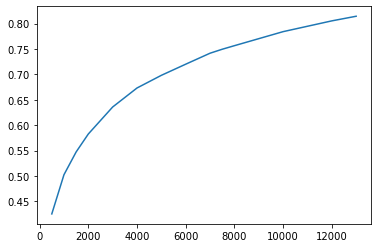

In [2]:
plt.plot(x,y)
plt.show()